In [29]:
import ticktack # For the compilation of the model
import ode      # As a method of solving the odes

from jax import jacfwd, jacrev, jit     # Forward and reverse mode the autodiff
from jax import numpy as np             # Importing the jax numpy 
import jax.experimental.ode as jax_ode  # Jax odeint 
from jax.lax import scan

import pandas as pd             # Becuase I want to 
from time import process_time   # For timing the different ode implementations
from os import getcwd
from functools import partial
from plotnine import *

I need to move this analysis into the `kitkat` environment and supercharge it

In [30]:
class odeint_linear(object):
    @classmethod
    def odeint(derivative, y0, timesteps, *args, **kwargs):
        step_size = timesteps[1] - timesteps[0]

        def step(y, time_value, step_size=None, derivative=None):
            next_time_value = y + derivative(y, time_value) * step_size
            return next_time_value, next_time_value

        step = partial(step, derivative=derivative, step_size=step_size)
        step = jit(step)

        _, y_values = scan(f=step, init=y0, xs=timesteps) 
        return y_values

In [31]:
#! Fix scope name shadowing 
parameters = np.array([ # Empty array to hold the parameters of the prodcution function 
    7.044873503263437,  # Mean of the sinusoidal production 
    0.18,               # Amplitude of the sinusoidal production 
    11.0,               # Period of the sinusoidal production 
    1.25,               # Phase of the sinusoidal production 
    120.05769867244142, # Height of the super-gaussian 
    12.0                # Width of the super-gaussian 
], dtype=np.float64)

In [32]:
projection = np.array([ # An array to hold the projection of the production function 
    0.7,    # Projection into the stratosphere 
    0.3,    # Projection into the troposphere 
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 
], dtype=np.float64)   

In [33]:
#! Type hints
def production(t, parameters):    
    """
    The production function defined as the sum of sinusoidal and super-gaussian terms 
    """
    return parameters[0] * (1 + parameters[1] * \
        np.sin(2 * np.pi / parameters[2] * t + parameters[3])) + \
        parameters[4] * np.exp(- (parameters[5] * (t - 775)) ** 16)

In [34]:
cbm = ticktack.load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()   # Constructing the transfer operator 

In [35]:
u0 = np.array([   # Housing the initial C14 concentr    ations 
    135.76261605786132, # Initial stratosphere concentration
    709.7591911307035,  # Initial troposphere concentration
    1191.489526709938,  # Initial surface ocean concentration
    3.97158546945107,   # Initial surface biota concentration 
    45158.65854589925,  # Initial deep ocean concentration
    155.54703228960028, # Initial short-lived biota concentration
    634.290736403387,   # Initial long-lived biota concentration
    423.5954241095565,  # Initial litter concentration
    1808.3343542055652, # Initial soil concentration 
    665.933052175064,   # Initial peat concentration
    7348.751626918585   # Initial sedimentary sink concentration 
], dtype=np.float64)

In [36]:
#! Need to improve the doc strings here
#? Look into jit compilation 
def dydx(y, t, p):
    """
    The gradient of the carbon box model.
    """
    return cbm._matrix @ y + production(t, p) * projection

In [37]:
def loss_function(odeint, dataset, dydx, u0, params=()):
    """
    The bayesian error of the loss function. 
    """
    d14c = np.array([*dataset["d14c"]], dtype=np.float64)   # JAX array for manipulation
    year = np.array([*dataset["year"]], dtype=np.float64)   # JAX array for the year
    sig_d14c = np.array([*dataset["sig_d14c"]], dtype=np.float64)# JAx array for manipulation 

    simulation = odeint(dydx, u0, year, params)[:, 2]   # Running the simulation 
    simulation = 1000 * (simulation - u0[2]) / u0[2]    # Deviations from initial 
    simulation += np.mean(d14c[1:4])    # Adding the offset 

    return - 0.5 * np.sum(((d14c - simulation) / sig_d14c) ** 2)   # Log likelhood as chi-squared 

In [38]:
def profile(func, args=[]) -> tuple:
    """
    Profiles the function, func, with the arguments, args, returning the speed and the variance of the speed.
    """
    time_sample = np.zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()                          # starting a timer 
        func(*args).block_until_ready()                                     # Running the model 
        time_sample = time_sample.at[i].set(process_time() - timer)   # Stopping the timer and storing 

    return np.mean(time_sample), np.var(time_sample)

So the problem is that the `*args` list is does not have the correct time_series information in it. I also need to majorly look at the binning

In [39]:
results = {
    "module": [],
    "time": [],
    "type": []
}

namespaces = {ode : "ode", jax_ode : "jax", odeint_linear: "linear"} # For translation from string to module 

dataset = pd.read_csv(f"{getcwd()}/datasets/775AD/NH/Miyake12_Cedar.csv") # Importing the miyake data

for namespace in namespaces:# Iterating through the namespaces of odeint function 
    mean, variance = profile(
        namespace.odeint, 
        [dydx, u0, np.arange(750.0, 820.0, 1/12), parameters]
    )   # Profiling the speed
    results["module"].append(namespaces[namespace])
    results["time"].append(float(mean) * 1000)
    results["type"].append("odeint")

    # Single variable function 
    loss = partial(loss_function, namespace.odeint, dataset, dydx, u0)

    # The gradients exist below 
    def gradient(p): 
        if namespaces[namespace] == "ode":
            return jacfwd(loss)(p)         # Calculating the gradient 
        else:
            return jacrev(loss)(p)

    mean, variance = profile(gradient, [parameters])

    results["module"].append(namespaces[namespace])
    results["time"].append(float(mean) * 1000)
    results["type"].append("gradient")

    def hessians(p): 
        if namespaces[namespace] == "ode":
            return jacfwd(jacfwd(loss))(p) # Calculating the hessian 
        else:
            return jacrev(jacrev(loss))(p)

    mean, variance = profile(hessians, [parameters])

    results["module"].append(namespaces[namespace])
    results["time"].append(float(mean) * 1000)
    results["type"].append("hessian")

TypeError: Value <function dydx at 0x7f1a705770d0> with type <class 'function'> is not a valid JAX type

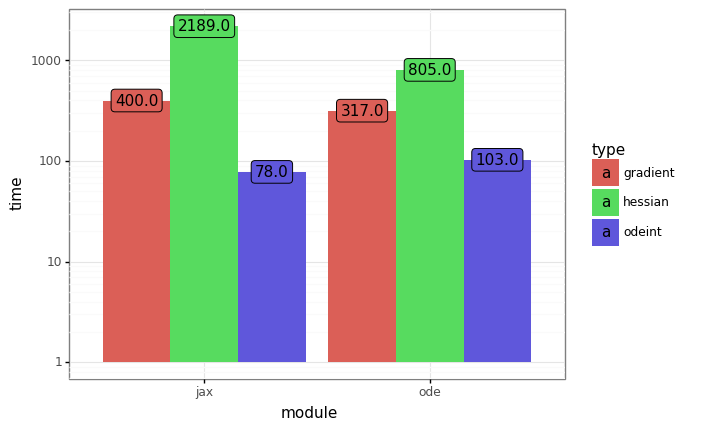

<ggplot: (8743019377800)>

In [ ]:
results = pd.DataFrame(results)  # Switching to a pandas data frame
(ggplot(results, aes(x="module", y="time", fill="type"))
    + geom_col(position="dodge")
    + geom_label(aes(label="round(time)"), position=position_dodge(width=0.9))
    + scale_y_log10()
    + theme_bw())